### Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optim
import emcee

### 1. Random gaussian "noise"
Read data from <true_values.txt> and add the gaussian displacement

In [2]:
c1, ceq = np.loadtxt('true_values.txt', unpack = True)
c1_bar = c1 + [np.random.normal(0,0.5) for i in range(len(c1))]
ceq_bar = ceq + [np.random.normal(0,0.5) for i in range(len(ceq))]

Store new data in output

In [3]:
fh = open('offset.dat', 'w')
fh.write('c1_tilde\tc_equivalent_tide\n')
lines = []
for i in range(len(c1)):
    fh.write('{0}\t{1}\n'.format(c1_bar[i],ceq_bar[i]))
fh.close()

### 2. Fit of the function
Definition of the model

In [4]:
def f(x, a, b):
    return 1/(b + 1/(x+a))
x = np.arange(1,100,0.01)

Fit of the data and print of the result

In [5]:
parameters, convariance = optim.curve_fit(f,c1_bar,ceq_bar)
print(" a = {0} +/- {1}\n b = {2} +/- {3}".format( parameters[0], convariance[0][0], parameters[1], convariance[1][1] ) )
true_a = parameters[0]
true_b = parameters[1]

 a = 9.630108873617157 +/- 0.02221015925707475
 b = 0.055389623657068704 +/- 1.0327740216866097e-08


Plot of the results

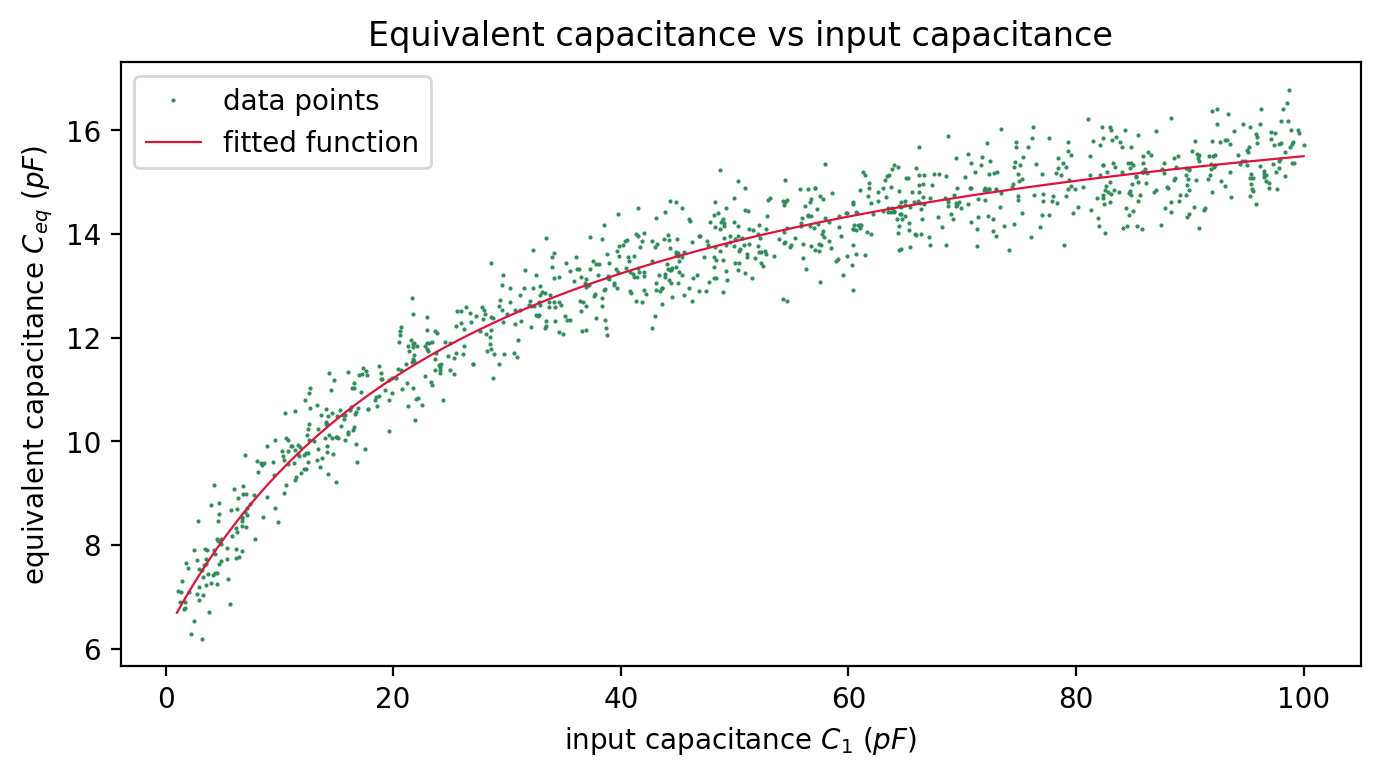

In [6]:
%matplotlib inline
plt.figure(111, figsize = (8,4), dpi = 200)
plt.plot(c1_bar, ceq_bar, label='data points', marker='.', markersize=1, color='seagreen', lw=0)
plt.plot(x, f(x, true_a, true_b), label="fitted function", color='crimson', lw = 0.8)
plt.title('Equivalent capacitance vs input capacitance')
plt.xlabel('input capacitance $C_1$ $(pF)$')
plt.ylabel('equivalent capacitance $C_{eq}$ $(pF)$')
plt.legend()
#plt.show()
plt.savefig("./fit.png")

### 3. Generation of $\Delta C_{eq}$

In [7]:
c1_err = [np.random.normal(0,3) for i in range(len(c1))]
ceq_err = [np.random.normal(0,3) for i in range(len(ceq))]

Store in output

In [8]:
fh = open('errorbar.dat', 'w')
fh.write('DeltaC1\tDeltaC_equivalent\n')
lines = []
for i in range(len(c1)):
    fh.write('{0}\t\t\t\t{1}\n'.format(c1_err[i],ceq_err[i]))
fh.close()

### 4. Monte Carlo
Definitions of probability densitiy funcions

In [9]:
def log_likelihood(theta, x, y, dy):
    a, b, log_f = theta
    sigma2 = dy**2 + f(x, a, b)**2*np.exp(2*log_f)
    
def log_prior(theta):
    a, b, log_f = theta
    if 0 < a < 20 and 0.0 < b < 1.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, dy):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, dy)

In [10]:
nwalkers = 32
n_parameters = 3
number_steps = 5000
fitted_a = true_b
fitted_b = true_a
fitted_log_f = 0
initial_par = fitted_a, fitted_b, fitted_log_f + 1e-3*np.random.randn(nwalkers, n_parameters)
sampler = emcee.EnsembleSampler(nwalkers, n_parameters, log_probability, args=(c1_bar, ceq, ceq_err))
sampler.run_mcmc(initial_par, number_steps, progress=True);

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: incompatible input dimensions (1, 3)